In [1]:
import sys
sys.path.insert(0, '/home/srivathsa/projects/HD-BET')

from HD_BET.run import run_hd_bet
import SimpleITK as sitk
import os
import pydicom
import numpy as np
from glob import glob
import tempfile
from subtle.subtle_preprocess import dcm_to_sitk, zoom_iso, zero_pad, center_crop
import matplotlib.pyplot as plt
import nibabel as nib
from tqdm import tqdm_notebook as tqdm

plt.set_cmap('gray')
plt.rcParams['figure.figsize'] = (10, 8)

def find_t1_series(dirpath_case):
    ser_nums = []
    for ser_dir in glob('{}/*'.format(dirpath_case)):
        if 't2' in ser_dir.lower() or 'flair' in ser_dir.lower(): continue
        dcm_file = [
            f for f in glob('{}/**/*'.format(ser_dir), recursive=True)
            if os.path.isfile(f) and 'XX' not in f
        ][0]
        dcm = pydicom.dcmread(dcm_file)
        ser_nums.append((ser_dir, dcm.SeriesNumber))

    ser_nums = sorted(ser_nums, key=lambda s: int(s[1]))
    return [s[0] for s in ser_nums]

def bet_volume(fpath, device=0):
    with tempfile.TemporaryDirectory() as tmpdir:
        fpath_input = '{}/input.nii.gz'.format(tmpdir)
        fpath_output = '{}/output.nii.gz'.format(tmpdir)
        img_sitk = dcm_to_sitk(fpath)
        sitk.WriteImage(img_sitk, fpath_input)

        run_hd_bet(fpath_input, fpath_output, mode='fast', device=device, do_tta=False)

        img_bet = nib.load(fpath_output).get_fdata()
        img_bet = img_bet.transpose(2, 1, 0)
        
    return img_bet, list(img_sitk.GetSpacing())[::-1]

def resize_vol(vol, hw=256, d=128):
    if vol.shape[1] > hw:
        vol_rs = center_crop(vol, np.zeros((vol.shape[0], hw, hw)))
    else:
        vol_rs = zero_pad(vol, target_size=hw)
    z_diff = (vol_rs.shape[0] - d) // 2
    return vol_rs[z_diff:-z_diff, ...]

def process_vol(fpath, gpu_device=0, hw=256, d=128, target_spacing=None, bet=True):
    if target_spacing is None:
        target_spacing = np.array([1, 1, 1])
    if bet:
        vol, spacing = bet_volume(fpath, device=gpu_device)
    else:
        img_sitk = dcm_to_sitk(fpath)
        vol = sitk.GetArrayFromImage(img_sitk)
        spacing = list(img_sitk.GetSpacing())[::-1]
    vol, _ = zoom_iso(vol, np.array(spacing), target_spacing)
    vol = resize_vol(vol)
    
    return vol

def scale_vol(vol):
    vol = np.clip(vol, 0, vol.max())
    vol = vol / vol.mean()
    vol = np.interp(vol, (vol.min(), vol.max()), (0, 1))
    return vol

/home/srivathsa/projects/SubtleGad/train/subtle/utils/hyperparameter.py:8: UserWarning: Module test_tube not found - hyperparameter related functions cannot be used
  warnings.warn('Module test_tube not found - hyperparameter related functions cannot be used')


<Figure size 432x288 with 0 Axes>

In [ ]:
dcm_path = '/home/srivathsa/projects/studies/gad/stanford/data'
dest_path = '/home/srivathsa/projects/studies/gad/vmorph/data/sford_raw_nobet'
cases = ["Patient_0086", "Patient_0092", "Patient_0095", "Patient_0102", "Patient_0207", "Patient_0250", 
         "Patient_0253", "Patient_0264", "Patient_0290", "Patient_0296", "Patient_0308", "Patient_0345", 
         "Patient_0356", "Patient_0362", "Patient_0366", "Patient_0367", "Patient_0409", "Patient_0572", 
         "Patient_0088", "Patient_0089", "Patient_0093"]

# cases = ['Patient_0149',
# 'Patient_0170',
# 'Patient_0171',
# 'Patient_0198',
# 'Patient_0262',
# 'Patient_0284',
# 'Patient_0444',
# 'Patient_0517',
# 'Patient_0523']

gpu_device = 5
iso_spacing = np.array([1.0, 1.0, 1.0])
for cnum in tqdm(cases, total=len(cases)):
    fpath_dcm = os.path.join(dcm_path, cnum)
    fpath_save = os.path.join(dest_path, '{}.npz'.format(cnum))
    
    fp_t1pre, fp_t1low, fp_t1post = find_t1_series(fpath_dcm)

    t1p_vol = process_vol(fp_t1pre, gpu_device=gpu_device, bet=False)
    t1l_vol = process_vol(fp_t1low, gpu_device=gpu_device, bet=False)
    t1c_vol = process_vol(fp_t1post, gpu_device=gpu_device, bet=False)
    
    data = np.array([t1p_vol, t1l_vol, t1c_vol])
    np.savez(fpath_save, data=data)

In [ ]:
src_path = '/home/srivathsa/projects/studies/gad/vmorph/data/sford_raw_nobet'
dest_path_post = '/home/srivathsa/projects/studies/gad/vmorph/data/sford_post_nobet/val'
dest_path_low = '/home/srivathsa/projects/studies/gad/vmorph/data/sford_low_nobet/val'

for cnum in tqdm(cases, total=len(cases)):
    t1pre, t1low, t1post = np.load(os.path.join(src_path, '{}.npz'.format(cnum)))['data']
    t1pre = scale_vol(t1pre)
    t1low = scale_vol(t1low)
    t1post = scale_vol(t1post)
    
    np.savez('{}/{}.npz'.format(dest_path_low, cnum), data=np.array([t1pre, t1low]))
    np.savez('{}/{}.npz'.format(dest_path_post, cnum), data=np.array([t1pre, t1post]))

In [ ]:
data = np.load('/home/srivathsa/projects/studies/gad/vmorph/data/sford_raw_nobet/Patient_0086.npz')['data']
plt.imshow(data[1, 64] - data[0, 64])

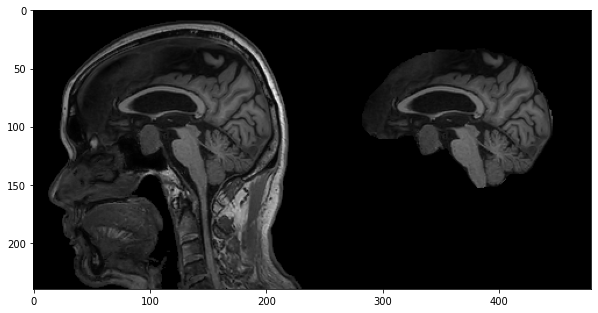

In [6]:
import subtle.utils.io as io_utils
data = io_utils.load_file('/home/srivathsa/projects/studies/gad/tiantan/preprocess/data/NO15.h5',
                  params={'h5_key': 'all'})

plt.imshow(np.hstack([data[0, 98, 0], data[1, 98, 0]]))

In [10]:
data_ax = data.transpose((0, 2, 3, 4, 1))

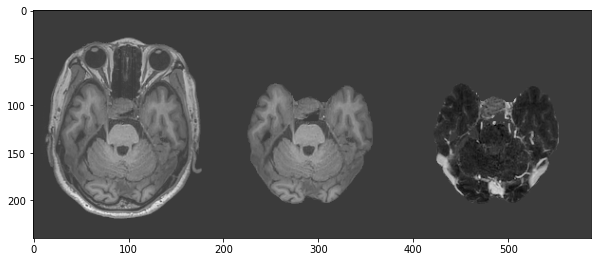

In [14]:
plt.imshow(np.hstack([data_ax[0, 0, 120], data_ax[1, 0, 120], data_ax[1, 2, 120]-data_ax[1, 0, 120]]))